
#The Complex Network Homework **No. 2**
Bahar Mahdavi - SN: 40152521337

## A. call the MUTAG dataset in torch_geometric.datasets and print its features including the number of available graphs, the number of classes, and the length of the feature vector.

###The installation of PyTorch Geometric (PyG) on Colab
PyTorch Geometric is an extension library to the popular deep learning framework PyTorch, and consists of various methods and utilities to ease the implementation of Graph Neural Networks.
https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

In [1]:
# Install torch geometric
!pip install torch-geometric

###Loading dataset

The **MUTAG dataset** consists of 188 chemical compounds divided into two classes according to their mutagenic effect on a bacterium.

MUTAG is a dataset contains 188 graphs representing molecules where the nodes are atoms (C, N, O, F, I, Cl, or Br) and the undirected edges are bonds (aromatic, single, double, or triple). Each graph comes with a target value of either 1 indicating mutagenicity (causing genetic mutation) or 0, meaning no mutagenicity. (DOI: 10.1021/jm00106a046)

The chemical data was obtained form http://cdb.ics.uci.edu and converted to graphs, where vertices represent atoms and edges represent chemical bonds. Explicit hydrogen atoms have been removed and vertices are labeled by atom type and edges by bond type (single, double, triple or aromatic). Chemical data was processed using the Chemistry Development Kit (v1.4).

In [2]:
import torch
from torch_geometric.datasets import TUDataset

# Load the MUTAG dataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset = dataset.shuffle()
data = dataset[0]  # Get the first graph object.

dataset.download()

Extracting data/TUDataset/MUTAG/MUTAG.zip


In [3]:
# print dataset features.
print(f'Dataset: {dataset}:')
print('=====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of features: {dataset.num_features}')
print()
print(f'Number of node features: {dataset.num_node_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of node labels: {dataset.num_node_labels}')
print(f'Number of edge labels: {dataset.num_edge_labels}')
print()
print(data)
print('=============================================================')

Dataset: MUTAG(188):
Number of graphs: 188
Number of classes: 2
Number of features: 7

Number of node features: 7
Number of edge features: 4
Number of node labels: 7
Number of edge labels: 4

Data(edge_index=[2, 44], x=[21, 7], edge_attr=[44, 4], y=[1])


In [4]:
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 21
Number of edges: 44
Average node degree: 2.10
Has isolated nodes: False
Has self-loops: False
Is undirected: True


###Graph visualization


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


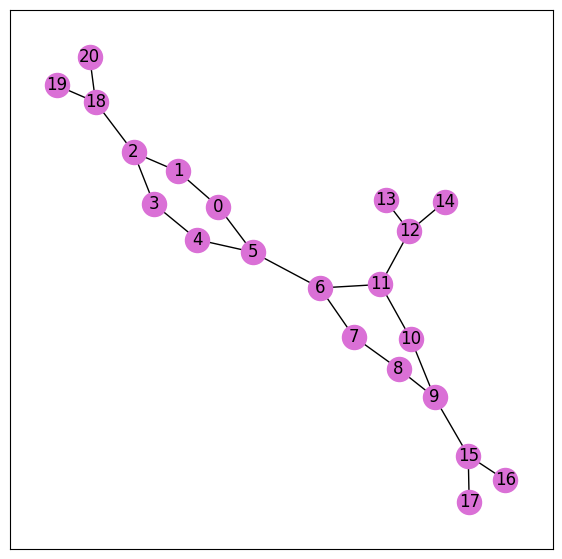

In [5]:
%matplotlib inline
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=10),
                     with_labels=True,
                     node_color='orchid',
                     cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [6]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20))

In [7]:
G.edges

EdgeView([(0, 1), (0, 5), (1, 2), (2, 3), (2, 18), (3, 4), (4, 5), (5, 6), (6, 7), (6, 11), (7, 8), (8, 9), (9, 10), (9, 15), (10, 11), (11, 12), (12, 13), (12, 14), (15, 16), (15, 17), (18, 19), (18, 20)])

## B. Design and train a graph neural network model to classify the given dataset and valuate the accuracy of your model and

### Split dataset into train and test

In [8]:
torch.manual_seed(10)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [9]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2572], x=[1163, 7], edge_attr=[2572, 4], y=[64], batch=[1163], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2396], x=[1094, 7], edge_attr=[2396, 4], y=[64], batch=[1094], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 918], x=[416, 7], edge_attr=[918, 4], y=[22], batch=[416], ptr=[23])



### Implementing the model

In [10]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(10)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch) # Pool node features to graph-level [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Training and test

In [11]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     loss_ = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss_ += loss.item()
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), loss_ / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(1, 301):
    train()
    train_acc, train_loss = test(train_loader)
    test_acc, test_loss = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0145, Test Loss: 0.0168
Epoch: 002, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0122, Test Loss: 0.0146
Epoch: 003, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0130, Test Loss: 0.0169
Epoch: 004, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0126, Test Loss: 0.0163
Epoch: 005, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0121, Test Loss: 0.0148
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0117, Test Loss: 0.0135
Epoch: 007, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0104, Test Loss: 0.0131
Epoch: 008, Train Acc: 0.6533, Test Acc: 0.7105, Train Loss: 0.0105, Test Loss: 0.0129
Epoch: 009, Train Acc: 0.7267, Test Acc: 0.6842, Train Loss: 0.0103, Test Loss: 0.0122
Epoch: 010, Train Acc: 0.7267, Test Acc: 0.7368, Train Loss: 0.0097, Test Loss: 0.0114
Epoch: 011, Train Acc: 0.7400, Test Acc: 0.7632, Train Loss: 0.0099, Test Loss: 0.0109
Epoch: 012, Train Acc: 0.8000, Test Acc: 0.

## C. Observe how the accuracy changes by varying the type of graph convolution (GCNConv, GraphConv, GAT, e.g.).

### Define GCNConv model

In [12]:
from torch_geometric.nn import GCNConv

class GCNConvModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(GCNConvModel, self).__init__()
        torch.manual_seed(10)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = GCNConvModel(num_node_features=7, num_classes=2, hidden_channels=64)
print(model)

GCNConvModel(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Define GATConv model

In [13]:
from torch_geometric.nn import GATConv

class GATConvModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(GATConvModel, self).__init__()
        torch.manual_seed(10)
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = GATConvModel(num_node_features=7, num_classes=2, hidden_channels=64)
print(model)

GATConvModel(
  (conv1): GATConv(7, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Define GraphConv model

In [14]:
from torch_geometric.nn import GraphConv

class GraphConvModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(GraphConvModel, self).__init__()
        torch.manual_seed(10)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = GraphConvModel(num_node_features=7, num_classes=2, hidden_channels=64)
print(model)

GraphConvModel(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Define SAGEConv model

In [15]:
from torch_geometric.nn import SAGEConv

class SAGEConvModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(SAGEConvModel, self).__init__()
        torch.manual_seed(10)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = SAGEConvModel(num_node_features=7, num_classes=2, hidden_channels=64)
print(model)

SAGEConvModel(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Define TransformerConv model

In [16]:
from torch_geometric.nn import TransformerConv

class TransformerConvModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels):
        super(TransformerConvModel, self).__init__()
        torch.manual_seed(10)
        self.conv1 = TransformerConv(dataset.num_node_features, hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels)
        self.conv3 = TransformerConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model = TransformerConvModel(num_node_features=7, num_classes=2, hidden_channels=64)
print(model)

TransformerConvModel(
  (conv1): TransformerConv(7, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
  (conv3): TransformerConv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Define train and evaluate model

In [17]:
def train_and_evaluate(model, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model
    model.train()
    for epoch in range(500):
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    loss_ = 0
    for data in test_loader:
        out = model(data)
        pred = out.argmax(dim=1)
        loss = criterion(out, data.y)
        loss_ += loss.item()
        correct += pred.eq(data.y).sum().item()
    accuracy = correct / len(test_loader.dataset)

    return accuracy

In [18]:
 hidden_channels=64

 models = {
    'GCN': GCNConvModel(dataset.num_node_features, dataset.num_classes, hidden_channels),
    'GAT': GATConvModel(dataset.num_node_features, dataset.num_classes, hidden_channels),
    'GraphConv': GraphConvModel(dataset.num_node_features, dataset.num_classes, hidden_channels),
    'SAGE': SAGEConvModel(dataset.num_node_features, dataset.num_classes, hidden_channels),
    'Transformer': TransformerConvModel(dataset.num_node_features, dataset.num_classes, hidden_channels)
}

In [19]:
for model_name, model in models.items():
    accuracy = train_and_evaluate(model, train_loader, test_loader)
    print(f'Accuracy of {model_name}: {accuracy:.4f}')

Accuracy of GCN: 0.8684
Accuracy of GAT: 0.7895
Accuracy of GraphConv: 0.9211
Accuracy of SAGE: 0.8421
Accuracy of Transformer: 0.7368


## D. Explain the mechanism of dividing graphic data into smaller batches (mini-batch) during the training process.

Recently, the training of GNNs has been widening to very large graphs. The number of nodes and the edges of these graphs reach millions to billions and the graphs with such scales make the ordinary naive software/hardware approaches ineffective. The earlier implementations of GNN were mostly focusing on a small scale graphs and assumed the whole graph fits into a single GPU memory. However, for large graphs whose node/edge feature data cannot fit into the GPU memory, at least part of the graph needs to be placed into the CPU memory. One common practice to train GNNs in such scenario is to create a smaller set of problem by performing a mini-batched training. With the mini-batch training, only a subset of nodes are randomly picked along with their neighboring nodes and sent to GPU. This method is very effective when training GNNs on large graphs as it practically reduces the memory footprint of the application. Overall, the use of mini-batches in the training process helps to manage memory usage, improve computational efficiency, and facilitate the training of graph-based machine learning models on large-scale graph data (1).

A mini-batch training process that places the all or part of the input graph feature data in the CPU memory needs to frequently transfer mini-batch data from CPU to GPU through a slow PCIe interconnect. Furthermore, the minibatch method amplifies the total amount of data access because the different minibatches can have overlapping nodes. Due to these reasons, training GNN is often throttled by CPU-GPU data transfer time (1).


The mechanism of dividing graph data into mini-batches during the training process aims to improve training speed and enhance the efficiency of training
in graph-based machine learning models, such as graph neural networks (GNNs). This approach optimizes the training process by using small batches of data instead of the entire dataset in each training step. By breaking down the data into mini-batches, it allows for leveraging parallel processing capabilities and optimizing memory usage, resulting in advantages in terms of speed and efficiency. Additionally, training on mini-batches can reduce the risk of overfitting as the model learns interactively on a small subset of data rather than fitting precisely to the entire dataset and preventing the model from memorizing the entire dataset. In a graph-based model, the input data is split into batches of a specified size using appropriate data structures and algorithms. During each training iteration, the network model is then trained on each mini-batch separately at a time, and after completing the training on each mini-batch, its parameters (weights) are updated based on the gradients computed on that mini-batch. This process iterates for multiple epochs until all data has been trained on or until the model converges or reaches a certain stopping criterion, such as reaching a specified number of training epochs or achieving the desired accuracy level (2).

The mechanism of dividing graph data into mini-batches during the training process faces particular challenges due to the connected and non-uniform structure of graphs. Below, the mechanism of batching graph data is explained in detail (2):

1. **Graph Aggregation into a Batch:**
   - **Graph Merging:** To create a batch, multiple independent graphs are aggregated into a larger graph. This process involves combining the node and edge lists of individual graphs.
   - **Preserving Graph Structure:** During aggregation, the edges of each individual graph are preserved separately to ensure that connections between nodes in different graphs are not established erroneously.

2. **Node Indexing:**
   - **Graph Indices (Batch Indices):** Graph indices are utilized to maintain information related to each graph within the batch. These indices indicate the source graph of each node in the batch.
   - **Adjusting Edge Indices:** Edge indices for each graph need to be adjusted to reflect the new positions of nodes in the batch. This adjustment is achieved by adding an offset to the edge indices of each graph.

3. **DataLoader Process in torch_geometric:**
   - **Automatic Aggregation:** DataLoader in torch_geometric streamlines the aggregation of graphs into batches automatically. This process entails the fusion of nodes, edges, and other graph features.
   - **Load Balancing:** DataLoader strives to balance the computational workload in each batch, considering variations in the number of nodes and edges across different graphs.

4. **Batch Processing in GNN:**
   - **Independent Node Computations:** In Graph Neural Networks (GNNs), computations for each node, including features and neighbors, are performed independently of other nodes. This enables parallel processing of multiple graphs within a batch.
   - **Utilizing Graph Indices:** Graph indices play a crucial role in node processing, ensuring that computations related to a specific graph in the batch are only applied to the nodes of that graph.

By implementing this mechanism, torch_geometric effectively categorizes graph data, enhancing computational efficiency while preserving the original structure and features of the graphs throughout the training process (2).

Current deep learning models for classification tasks in computer vision are trained using minibatches. They take advantage of the relationships between samples in a minibatch, using graph neural networks to aggregate information from similar images. This helps mitigate the adverse effects of alterations to the input images on classification performance. Diverse experiments on image-based object and scene classification show that this approach not only improves a classifier’s performance but also increases its robustness to image perturbations and adversarial attacks. Further, mini-batch graph neural networks can help to alleviate the problem of mode collapse in Generative Adversarial Networks (3).

In most of these settings, the training data is divided into mini-batches to adjust to limitations in computational and memory resources. Within a particular mini-batch, the input images may have varying degrees of similarity between them. Exploiting this variability during the feature encoding stage has the potential to improve the performance of downstream computer vision tasks. Motivated by this idea, different approaches have been proposed to take advantage of the relationships between samples in a mini-batch for computer vision tasks, and in particular for image-based classification. These approaches all explicitly encourage the embeddings in the feature space to be close to one another when the underlying images are similar, by using an extra similarity based loss term (3).

One of these approach is based on the construction of a graph from each mini-batch of samples, which allows information to be pooled across those with similar features, using graph convolution operations. As such, the requirement that similar images have similar embeddings is implicit, in that no additional loss term has to be optimized. This allows for the aggregation of features during training in a manner that adjusts dynamically to each particular mini-batch ensemble of images. A perturbation analysis explains how this, in turn, affords a degree of robustness to input image alterations and adversarial attacks (3).

References:
1. Min, Seung Won, et al. "Graph neural network training and data tiering." Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining. 2022.
2. ChatGPT
3. Mondal, Arnab Kumar, Vineet Jain, and Kaleem Siddiqi. "Mini-batch graphs for robust image classification." arXiv preprint arXiv:2105.03237 (2021).